In [65]:
from urllib.request import urlretrieve
import zipfile
import os
from datetime import date, datetime
import pandas as pd

In [118]:
%matplotlib inline

In [42]:
def download_year(year):
    file_path = f'files/{year}.zip'
    urlretrieve(f'http://bvmf.bmfbovespa.com.br/InstDados/SerHist/COTAHIST_A{year}.ZIP', file_path)
    return file_path

In [11]:
def unzip(file_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall('files/')

In [12]:
def _to_float(s):
    return float(s[:-2] + '.' + s[-2:])

In [81]:
def _get_info(line):
    return {
        'date': line[2:10],
        'trading_code': line[12:23].strip(),
        'short_name': line[27:38].strip(),
        'open': _to_float(line[56:69].strip()),
        'high': _to_float(line[70:82].strip()),
        'low': _to_float(line[83:95].strip()),
        'close': _to_float(line[109:121].strip()),
        'bid': _to_float(line[122:134].strip()),
        'ask': _to_float(line[135:147].strip()),
        'volume': _to_float(line[170:187].strip())
    }

In [99]:
years = list(range(2016, 2022))

In [ ]:
for year in years:
    file = download_year(year)
    unzip(file)

In [44]:
!ls files

COTAHIST_A2016.TXT COTAHIST_A2018.TXT COTAHIST_A2020.TXT
COTAHIST_A2017.TXT COTAHIST_A2019.TXT COTAHIST_A2021.TXT


In [100]:
files = [f'files/COTAHIST_A{year}.TXT' for year in years]

In [102]:
def parse_file(path):
    with open(path, 'r') as file:
        content = file.read()
        
    lines = content.split('\n')[1:-2]   # drop header and footer
    df = pd.DataFrame([_get_info(line) for line in lines])
    df['date'] = df['date'].map(lambda d: datetime.strptime(d, '%Y%m%d'))
    return df.rename({'trading_code': 'ticker'}, axis=1).drop('short_name', axis=1).set_index(['date', 'ticker'])

In [107]:
def make_df(files, ticker):
    full_df = pd.DataFrame()
    for file in files:
        df = parse_file(file)
        df = df.reset_index()
        df = df[df['ticker'] == ticker]
        full_df = full_df.append(df.set_index('date'), sort=True)
        
    df = full_df.sort_index()
    df = df[['open', 'close']]
    df['next_open'] = df['open'].shift(-1)
    df = df.dropna()
    df['overnight'] = df['next_open'] / df['close'] - 1
    return df

### I'll start with 1 year

In [108]:
df = make_df(['files/COTAHIST_A2021.TXT'], 'ITUB4')   # using itub because they pay a lot of dividends

In [95]:
# possible candidates, just out of curiosity
df[df['overnight'] < df['overnight'].mean() - 2 * df['overnight'].std()]

,open,close,next_open,overnight
date,,,,
2021-02-19,27.89,27.62,26.55,-0.038740
2021-10-01,29.12,29.67,24.75,-0.165824


Checking other sources, indeed there was a dividend on 2021-10-01, but not on 2021-02-19, and there were maany others that didn't show up on this simple filter, so not a great filter

In [98]:
df.to_parquet('data/itub_2021.parquet')

---

#### I'll try the full 6 years of vale now, their divs are usually larger

In [111]:
df = make_df(files, 'VALE3')

In [112]:
df

,open,close,next_open,overnight
date,,,,
2016-01-04,12.49,12.69,12.67,-0.001576
2016-01-05,12.67,12.52,12.08,-0.035144
2016-01-06,12.08,11.60,11.26,-0.029310
2016-01-07,11.26,10.91,11.07,0.014665
2016-01-08,11.07,10.54,10.50,-0.003795
...,...,...,...,...
2021-12-22,79.89,79.92,79.95,0.000375
2021-12-23,79.95,79.15,78.87,-0.003538
2021-12-27,78.87,78.95,78.51,-0.005573


<AxesSubplot:xlabel='date'>

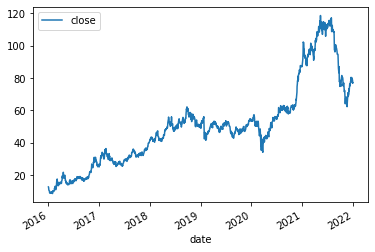

In [117]:
df.plot(y='close')

looks right

In [116]:
df.to_parquet('data/vale.parquet')